# Rescheduling mit Flow Time
> Planunghorizont Tag 0: 2 Tage
> Rescheduling des Tages 1

In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

import src.utils.gen_interarrival as gen_interarrival
import src.utils.gen_jobs as gen_jobs

import time
import pandas as pd
pd.set_option('display.max_rows', 26)

In [2]:
import src.models.lp.flowtime_solver as solver
from src.simulation.ProductionDaySimulation import ProductionDaySimulation

In [3]:
max_time = 60*2 # 5min

In [4]:
#import utils.scheduling_solver as ssv
#import utils.rescheduling_solver as rssv
#from ProductionDaySimulation import ProductionDaySimulation

In [5]:
basic_data_path = get_path("data", "basic")

df_instance = pd.read_csv(basic_data_path / "00_instance.csv")
df_instance

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


### 1) Aufträge generieren

In [6]:
df_jssp = gen_jobs.create_multiple_jobs(df_instance, repetitions = 4, shuffle = True)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
395,Job_039,5,M9,76
396,Job_039,6,M5,47
397,Job_039,7,M3,52
398,Job_039,8,M4,90


### 2) Mittlere Interarrival-Zeit berechnen

In [7]:
t_a = gen_interarrival.calculate_mean_interarrival_time(df_jssp, u_b_mmax= 0.92)
t_a

68.59

### 3) Ankunftszeiten erzeugen

In [8]:
df_jobs_arrivals = gen_interarrival.generate_arrivals(df_jssp, mean_interarrival_time=t_a, start_time=0.0)
df_jobs_arrivals

,Job,Arrival
0,Job_000,0.00
1,Job_001,83.09
2,Job_002,103.88
3,Job_003,145.10
4,Job_004,181.06
...,...,...
35,Job_035,1859.79
36,Job_036,2203.28
37,Job_037,2206.80
38,Job_038,2214.72


### 4) Nur Jobs behalten, deren Ankunft im Zeitfenster liegt

In [9]:
day_count = 1

time_limit = 60 * 24 * day_count
df_jobs_arrivals = df_jobs_arrivals[df_jobs_arrivals['Arrival'] < time_limit].reset_index(drop=True)
df_jobs_arrivals

,Job,Arrival
0,Job_000,0.00
1,Job_001,83.09
2,Job_002,103.88
3,Job_003,145.10
4,Job_004,181.06
...,...,...
24,Job_024,1265.29
25,Job_025,1279.37
26,Job_026,1297.57
27,Job_027,1420.54


In [10]:
valid_jobs = set(df_jobs_arrivals['Job'])
df_jssp = df_jssp[df_jssp['Job'].isin(valid_jobs)].reset_index(drop=True)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
285,Job_028,5,M5,11
286,Job_028,6,M6,62
287,Job_028,7,M7,56
288,Job_028,8,M8,44


In [11]:
# df_jssp, df_jobs_arrivals = gen_jobs.create_jobs_for_days(df_instance, day_count = 1, u_b_mmax= 0.92, shuffle = True)
# df_jobs_arrivals

## I) Complete Scheduling

In [12]:
starting_time = time.time()

# Scheduling
df_plan = solver.solve_jssp_flowtime(df_jssp, df_jobs_arrivals, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.10)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan

BigM: 17000

Solver-Informationen:
  Summe Flow Times        : 35519.91
  Solver-Status           : Optimal
  Anzahl Variablen        : 4379
  Anzahl Constraints      : 8410

Scheduling-Dauer: 2 Minuten und 0.27 Sekunden.


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,29.0,29.00,29.00
1,Job_000,1,0.00,M1,29.00,78.0,107.00,107.00
2,Job_001,0,83.09,M0,83.09,43.0,43.00,126.09
3,Job_000,2,0.00,M2,107.00,9.0,116.00,116.00
4,Job_002,0,103.88,M1,107.00,91.0,94.12,198.00
...,...,...,...,...,...,...,...,...
285,Job_028,9,1421.27,M9,3268.92,21.0,1868.65,3289.92
286,Job_027,6,1420.54,M8,3311.92,19.0,1910.38,3330.92
287,Job_027,7,1420.54,M9,3330.92,48.0,1958.38,3378.92
288,Job_027,8,1420.54,M7,3378.92,36.0,1994.38,3414.92


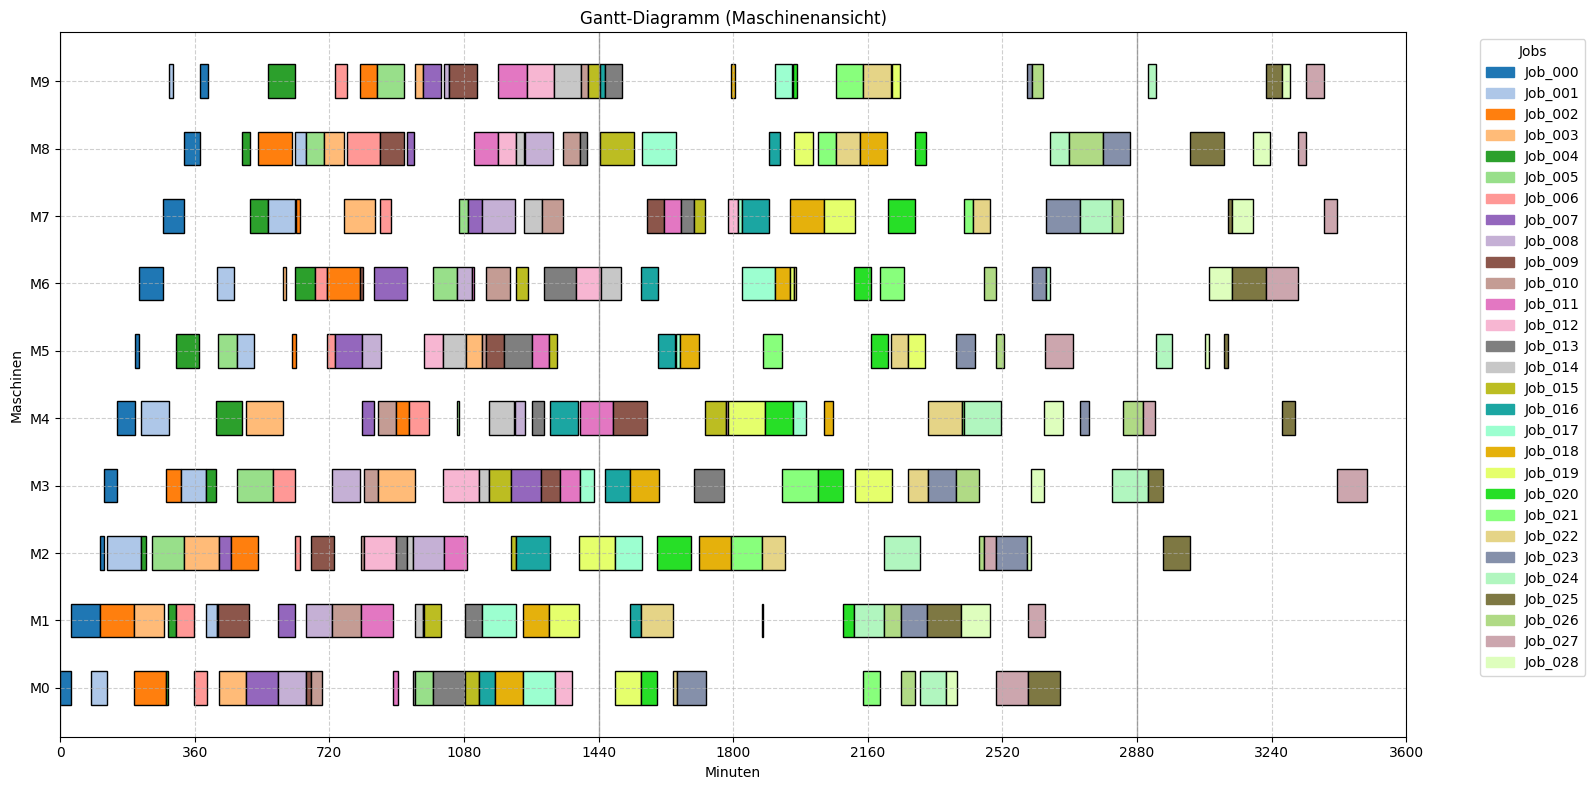

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [13]:
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

## II) Erster Tag (Tag 0)

### a) Simulation

In [16]:
day_length = 1440

In [17]:
day_numb = 0

day_start = day_length*day_numb 
day_end = day_start + day_length

In [18]:
simulation = ProductionDaySimulation(df_plan, vc=0.35)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[01:16:09] Job_000 finished on M0 (after 76 minutes 10 seconds)
[01:16:09] Job_000 started on M1
[01:23:05] Job_001 started on M0
[01:47:43] Job_001 finished on M0 (after 24 minutes 38 seconds)
[02:05:31] Job_000 finished on M1 (after 49 minutes 22 seconds)
[02:05:31] Job_002 started on M1
[02:05:31] Job_000 started on M2
[02:15:39] Job_000 finished on M2 (after 10 minutes 08 seconds)
[02:15:39] Job_001 started on M2
[02:15:39] Job_000 started on M3
[02:50:33] Job_000 finished on M3 (after 34 minutes 54 seconds)
[02:50:33] Job_000 started on M4
[03:12:14] Job_002 finished on M1 (after 66 minutes 43 seconds)
[03:18:00] Job_003 started on M1
[03:18:00] Job_002 started on M0
[03:33:09] Job_000 finished on M4 (after 42 minutes 35 seconds)
[03:33:09] Job_000 started on M5
[03:39:08] Job_001 finished on M2 (after 83 minutes 29 seconds)
[03:39:08] Job_004 started on M2
[03:39:08] Job_001 started on M4
[03:44:02] Job_000 finished on M5 (after 10 minutes 53 seco

In [19]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_014,7,548.96,M7,1240.92,49.0
1,Job_008,9,336.84,M8,1242.92,74.0
2,Job_016,2,623.69,M4,1309.92,75.0
3,Job_014,8,548.96,M9,1319.92,72.0
4,Job_011,7,509.07,M3,1337.92,52.0
...,...,...,...,...,...,...
137,Job_028,9,1421.27,M9,3268.92,21.0
138,Job_027,6,1420.54,M8,3311.92,19.0
139,Job_027,7,1420.54,M9,3330.92,48.0
140,Job_027,8,1420.54,M7,3378.92,36.0


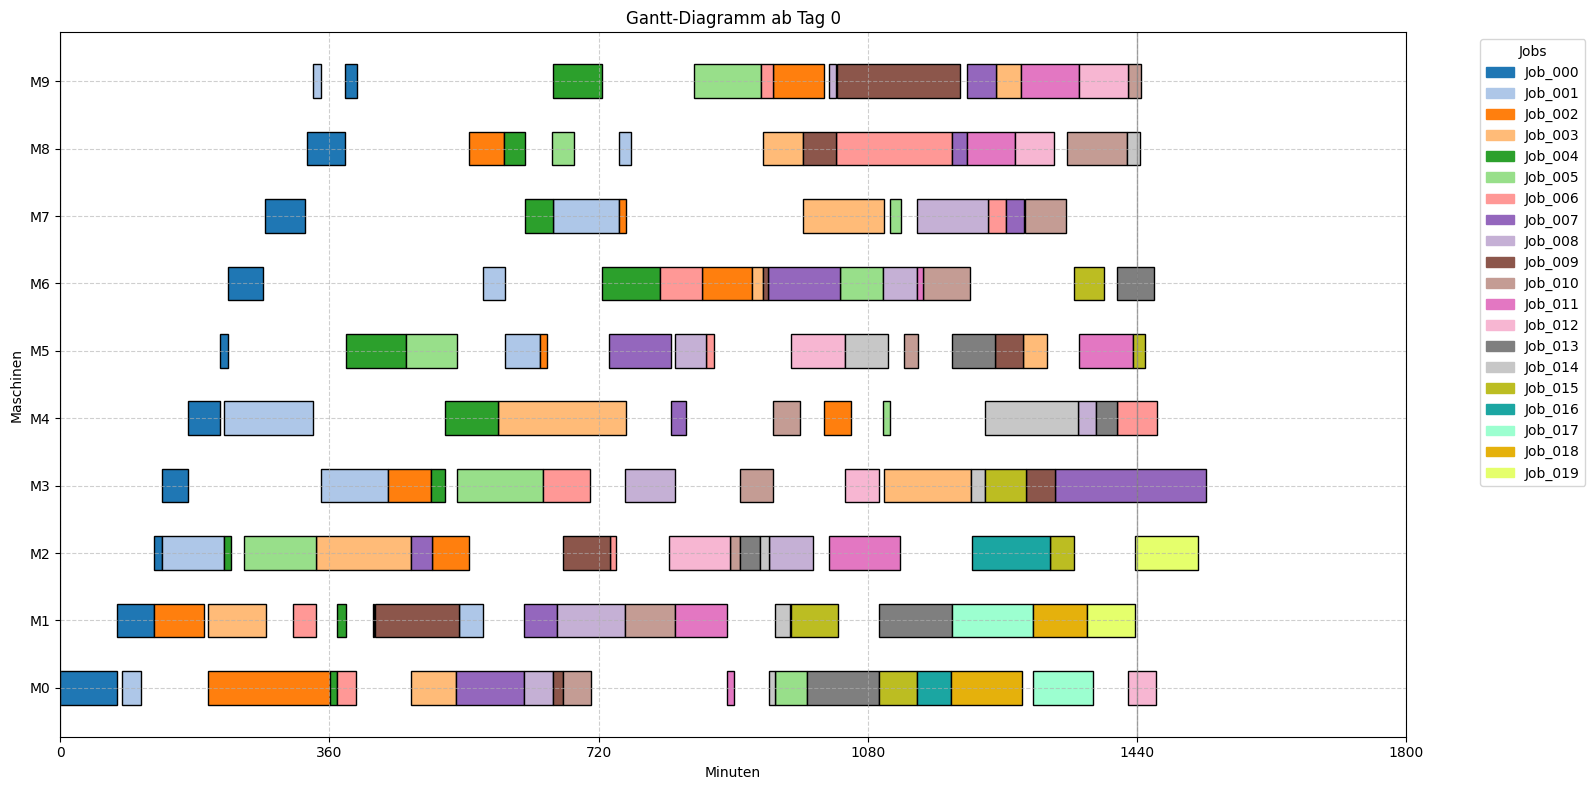

In [20]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm ab Tag {day_numb}", duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

### b) Verbleibene Jobs (Rest)

In [21]:
df_rest = df_plan.merge(df_execution[["Job", "Machine"]], on=["Job", "Machine"], how="left", indicator=True)
df_rest = df_rest[df_rest["_merge"] == "left_only"].drop(columns=["_merge"])
df_rest = df_rest.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_rest

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_008,9,336.84,M8,1242.92,74.0,980.08,1316.92
1,Job_009,8,419.90,M4,1479.92,90.0,1150.02,1569.92
2,Job_009,9,419.90,M7,1569.92,45.0,1195.02,1614.92
3,Job_011,7,509.07,M3,1337.92,52.0,880.85,1389.92
4,Job_011,8,509.07,M4,1389.92,90.0,970.85,1479.92
...,...,...,...,...,...,...,...,...
137,Job_028,5,1421.27,M5,3061.92,11.0,1651.65,3072.92
138,Job_028,6,1421.27,M6,3072.92,62.0,1713.65,3134.92
139,Job_028,7,1421.27,M7,3134.92,56.0,1769.65,3190.92
140,Job_028,8,1421.27,M8,3190.92,44.0,1813.65,3234.92


In [23]:
allowed = df_rest["Job"].unique() 
df_time_rest = df_jobs_arrivals[df_jobs_arrivals["Job"].isin(allowed)].copy()
df_time_rest

,Job,Arrival
8,Job_008,336.84
9,Job_009,419.90
11,Job_011,509.07
12,Job_012,516.39
13,Job_013,547.02
14,Job_014,548.96
15,Job_015,567.55
16,Job_016,623.69
17,Job_017,639.27
18,Job_018,696.89


## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [24]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
69,Job_006,9,305.93,M4,1412.74,53.49,1160.30,1466.23
79,Job_007,9,322.49,M3,1330.27,201.80,1209.58,1532.07
106,Job_010,9,463.55,M9,1427.89,18.14,982.48,1446.03
120,Job_012,6,516.39,M0,1427.89,37.02,948.52,1464.91
126,Job_013,5,547.02,M6,1412.74,49.45,915.17,1462.19
133,Job_014,6,548.96,M8,1427.19,16.91,895.14,1444.10
139,Job_015,5,567.55,M5,1435.21,15.49,883.15,1450.70
147,Job_019,1,825.58,M2,1436.76,84.64,695.82,1521.40


In [25]:
df_reschedule = solver.solve_jssp_individual_flowtime_with_fixed_ops(df_rest, df_time_rest, df_execution_important,
                                                                   reschedule_start = 1440,
                                                                   solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.10)
df_reschedule

BigM: 9000

Solver-Informationen:
  Summe Flow Times        : 27373.51
  Solver-Status           : Optimal
  Anzahl Variablen        : 1255
  Anzahl Constraints      : 2348


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_026,0,1297.57,M1,1440.00,46.0,188.43,1486.00
1,Job_008,9,336.84,M8,1444.10,74.0,1181.26,1518.10
2,Job_014,7,548.96,M7,1444.10,49.0,944.14,1493.10
3,Job_015,6,567.55,M9,1450.70,32.0,915.15,1482.70
4,Job_012,7,516.39,M6,1464.91,65.0,1013.52,1529.91
...,...,...,...,...,...,...,...,...
137,Job_025,5,1279.37,M5,2757.91,10.0,1488.54,2767.91
138,Job_025,6,1279.37,M7,2767.91,12.0,1500.54,2779.91
139,Job_025,7,1279.37,M6,2779.91,89.0,1589.54,2868.91
140,Job_025,8,1279.37,M9,2868.91,45.0,1634.54,2913.91


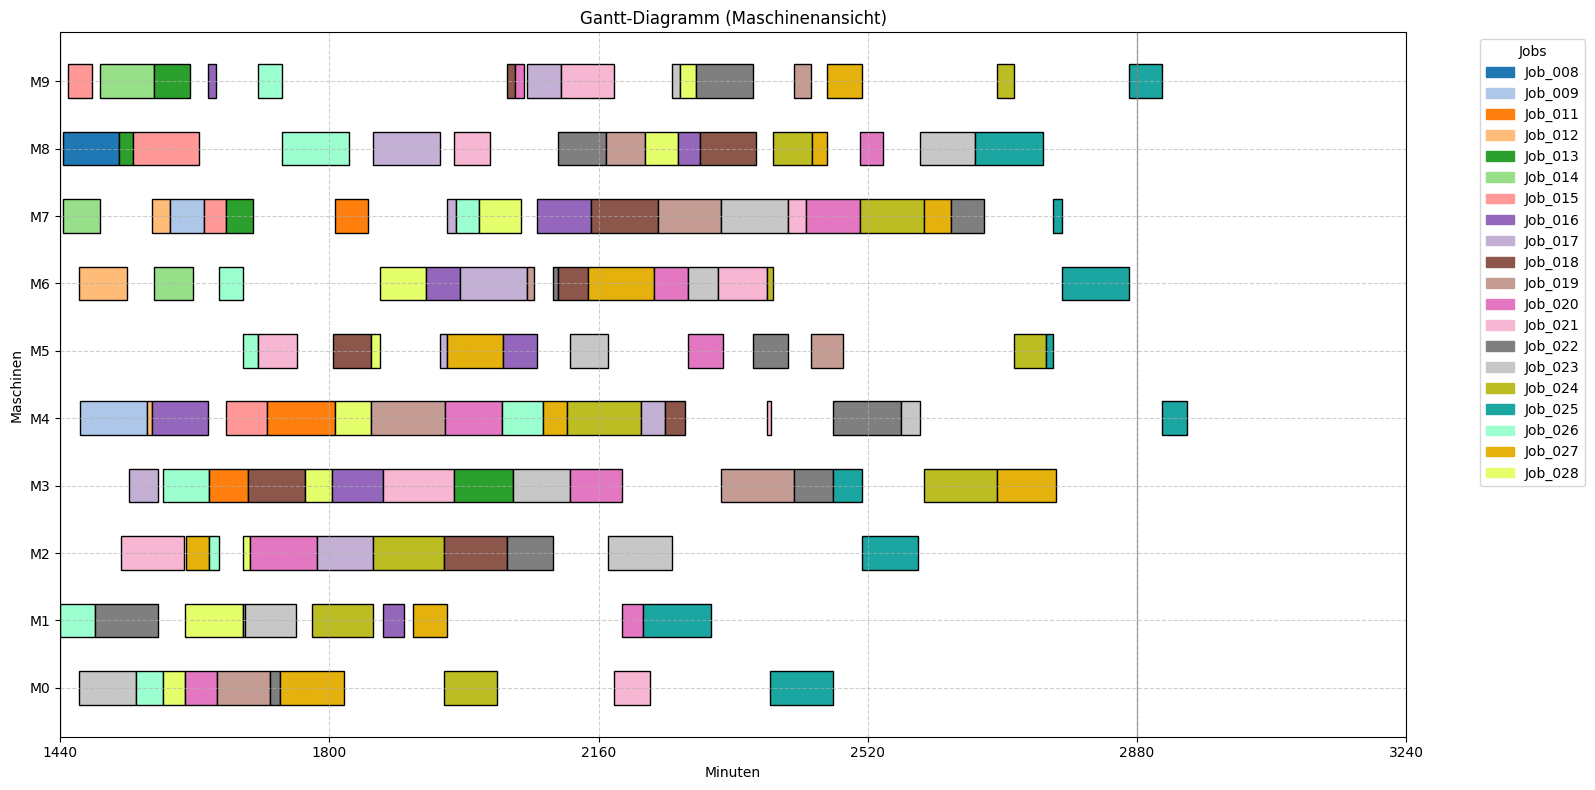

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [26]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)